In [48]:
# Cell A1: Load downsampled water mask for CA

import json
from pathlib import Path

import numpy as np
import rasterio
from rasterio.enums import Resampling

# ---- CONFIG ----
# Folder where you ran DataPreparation(base_path=...)
BASE_PATH = Path(r"C:\CAEE Hackthon")  # <-- UPDATE THIS
CATALOG_PATH = BASE_PATH / "processed_data" / "data_catalog.json"

# Choose one of your communities from the catalog keys, e.g. "quinhagak"
COMMUNITY_NAME = "quinhagak"  # <-- UPDATE THIS

# Max CA grid size (higher = slower, but more detailed)
CA_MAX_SIZE = 512   # try 128 or 256


def load_water_mask_for_ca(water_mask_path: Path, target_size: int = 128):
    """
    Read the water mask TIF, downsample it for the CA, and compute cell size in meters.
    """
    with rasterio.open(water_mask_path) as src:
        mask = src.read(1).astype(np.uint8)
        height, width = mask.shape

        # Average pixel size (m) from geotransform
        pixel_width = abs(src.transform.a)
        pixel_height = abs(src.transform.e)
        pixel_size_m = (pixel_width + pixel_height) / 2.0

        max_dim = max(height, width)

        if max_dim > target_size:
            scale = target_size / max_dim
            new_h = int(round(height * scale))
            new_w = int(round(width * scale))

            data = src.read(
                1,
                out_shape=(1, new_h, new_w),
                resampling=Resampling.nearest
            ).astype(np.uint8)

            cell_size_m = pixel_size_m / scale
        else:
            data = mask
            cell_size_m = pixel_size_m

    # Map water mask to CA states: assume water_mask==1 is water, 0 is land
    # WATER = 0, LAND = 4, interior will erode down through 3,2,1,0
    grid = np.where(data == 1, 0, 4).astype(np.int8)

    return grid, cell_size_m


# ---- Load catalog and get paths ----
with open(CATALOG_PATH, "r") as f:
    catalog = json.load(f)

entry = catalog["communities"][COMMUNITY_NAME]
water_mask_path = Path(entry["water_mask_path"])
weather_json_path = Path(entry["weather_json"])

grid, cell_size_m = load_water_mask_for_ca(water_mask_path, target_size=CA_MAX_SIZE)

print(f"Loaded community: {COMMUNITY_NAME}")
print(f"CA grid shape: {grid.shape}")
print(f"Approx cell size (m): {cell_size_m:.1f}")



Loaded community: quinhagak
CA grid shape: (290, 388)
Approx cell size (m): 0.0


In [50]:
#Probability that a cell erodes one level if it has water neighbors
# Cell B1: Configure erosion probabilities from weather + waves

import numpy as np
import json

def configure_erosion_parameters(weather_json_path: Path, cell_size_m: float):
    """
    Use storm_intensity, wave_height, avg_wave_period to estimate
    an annual erosion rate (m/yr), then convert to CA probabilities.
    """
    with open(weather_json_path, "r") as f:
        w = json.load(f)

    storm_I = float(w.get("storm_intensity", 0.5))      # 0–1
    Hs = float(w.get("wave_height", 2.0))               # m, avg last 24h
    Tm = float(w.get("avg_wave_period", 7.0) or 7.0)    # s

    # 1. Wave power proxy (normalized)
    #   Wave impact often scales with Hs^2 * Tm (wave energy flux).
    wave_power_index = (Hs ** 2) * Tm / 50.0  # 50 is a rough normalization constant

    # 2. Component erosion rates (m/yr)
    #    These magnitudes are chosen so that typical Hs~1–3 m and storm_I~0.3–0.7
    #    give E_total ~1–10 m/yr, consistent with observed Arctic coastal erosion. 
    E_uniform = 0.2      # instead of 0.5
    E_wave    = 2.0 * wave_power_index  # instead of 4.0
    E_storm   = 2.0 * storm_I           # instead of 4.0
    E_total = np.clip(E_uniform + E_wave + E_storm, 0.0, 20.0)
    erosion_prob = float(min(0.5, E_total / cell_size_m))  # drop factor 2, cap at 0.5


    # 3. Convert to CA probabilities.
    #    We want expected coastline retreat ~ E_total / cell_size_m cells per year.
    #    Your CA uses prob_coastal = EROSION_PROB * (eroded_neighbors / 4).
    #    For an average of ~2 eroded water neighbors, multiply by 2 to compensate.
    erosion_prob = float(min(0.9, 2.0 * E_total / cell_size_m))

    # Rain-/storm-driven background erosion inland (small)
    rain_prob = float(min(0.1, 0.02 + 0.08 * storm_I))

    meta = {
        "E_uniform_m_per_year": float(E_uniform),
        "E_wave_m_per_year": float(E_wave),
        "E_storm_m_per_year": float(E_storm),
        "E_total_m_per_year": float(E_total),
        "storm_intensity": float(storm_I),
        "wave_height_m": float(Hs),
        "avg_wave_period_s": float(Tm),
        "wave_power_index": float(wave_power_index),
        "cell_size_m": float(cell_size_m),
    }
    return erosion_prob, rain_prob, meta


EROSION_PROB, RAIN_EROSION_PROB, erosion_meta = configure_erosion_parameters(
    weather_json_path, cell_size_m
)

print("=== Erosion parameters configured ===")
for k, v in erosion_meta.items():
    print(f"{k}: {v:.3f}" if isinstance(v, float) else f"{k}: {v}")
print(f"\nEROSION_PROB:      {EROSION_PROB:.3f}")
print(f"RAIN_EROSION_PROB: {RAIN_EROSION_PROB:.3f}")



# Create custom colormap: blue gradients for water/erosion, yellow for land
colors = ['#0047ab', '#3366cc', '#6699ff', '#99ccff', '#ffcc00']  # Dark blue -> light blue -> yellow
n_bins = 5
cmap = LinearSegmentedColormap.from_list('erosion', colors, N=n_bins)

=== Erosion parameters configured ===
E_uniform_m_per_year: 0.200
E_wave_m_per_year: 0.234
E_storm_m_per_year: 0.827
E_total_m_per_year: 1.261
storm_intensity: 0.413
wave_height_m: 0.985
avg_wave_period_s: 6.019
wave_power_index: 0.117
cell_size_m: 0.000

EROSION_PROB:      0.900
RAIN_EROSION_PROB: 0.053


In [51]:
def count_water_neighbors(grid, i, j):
    """Count cells with lower erosion state in the 4 adjacent neighbors"""
    count = 0
    current_state = grid[i, j]
    for di, dj in [(-1,0), (1,0), (0,-1), (0,1)]:
        ni, nj = i + di, j + dj
        if 0 <= ni < SIZE and 0 <= nj < SIZE:
            # Count neighbors with lower state (more eroded)
            if grid[ni, nj] < current_state:
                count += 1
    return count

In [52]:
# Cell C1: Cellular automaton rules for erosion

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# States
WATER = 0
ERODING_3 = 1  # heavily eroded
ERODING_2 = 2  # moderately eroded
ERODING_1 = 3  # slightly eroded
LAND = 4       # solid land

# Color map for plotting
colors = ['#0047ab', '#3366cc', "#a3fee9", "#F1E18F", '#ffcc00']
cmap = LinearSegmentedColormap.from_list('erosion', colors, N=5)


def count_water_neighbors(grid: np.ndarray, i: int, j: int) -> int:
    """
    Count adjacent neighbors (4-connected) that are more eroded (lower state value).
    """
    rows, cols = grid.shape
    count = 0
    current_state = grid[i, j]

    for di, dj in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
        ni, nj = i + di, j + dj
        if 0 <= ni < rows and 0 <= nj < cols:
            if grid[ni, nj] < current_state:  # more eroded
                count += 1

    return count


def update_grid(grid: np.ndarray) -> np.ndarray:
    """
    Apply erosion rules:
    - Coastal erosion: land cells adjacent to more eroded / water neighbors
      erode with probability based on EROSION_PROB.
    - Background (rain/thermokarst) erosion: low-prob everywhere.
    """
    rows, cols = grid.shape
    new_grid = grid.copy()

    for i in range(rows):
        for j in range(cols):
            current_state = grid[i, j]

            # Skip water
            if current_state == WATER:
                continue

            # Coastal erosion: depends on neighbors
            eroded_neighbors = count_water_neighbors(grid, i, j)
            if eroded_neighbors > 0:
                prob_coastal = EROSION_PROB * (eroded_neighbors / 4.0)
                if np.random.random() < prob_coastal:
                    new_grid[i, j] = max(WATER, current_state - 1)
                    continue

            # Background erosion (rain / permafrost thaw)
            if np.random.random() < RAIN_EROSION_PROB:
                new_grid[i, j] = max(WATER, current_state - 1)

    return new_grid


# Flood helper, using grid shape instead of SIZE
flood_state = ERODING_3

def storm_flood(grid: np.ndarray, flood_intensity: int = 2) -> np.ndarray:
    """
    Simulate a short-term flood that weakens land near the water.
    """
    rows, cols = grid.shape
    storm_grid = grid.copy()

    # “Near coast” = columns within flood_intensity of existing water
    # Simple heuristic: for each row, find leftmost water and affect neighbors inland.
    for i in range(rows):
        water_cols = np.where(grid[i, :] == WATER)[0]
        if len(water_cols) == 0:
            continue
        coast_col = water_cols.max()  # furthest inland water in this row

        start_j = coast_col
        end_j = min(cols, coast_col + flood_intensity)

        for j in range(start_j, end_j):
            if storm_grid[i, j] == LAND:
                storm_grid[i, j] = flood_state

    print("Flooding is in effect")
    return storm_grid


Flooding is in effect


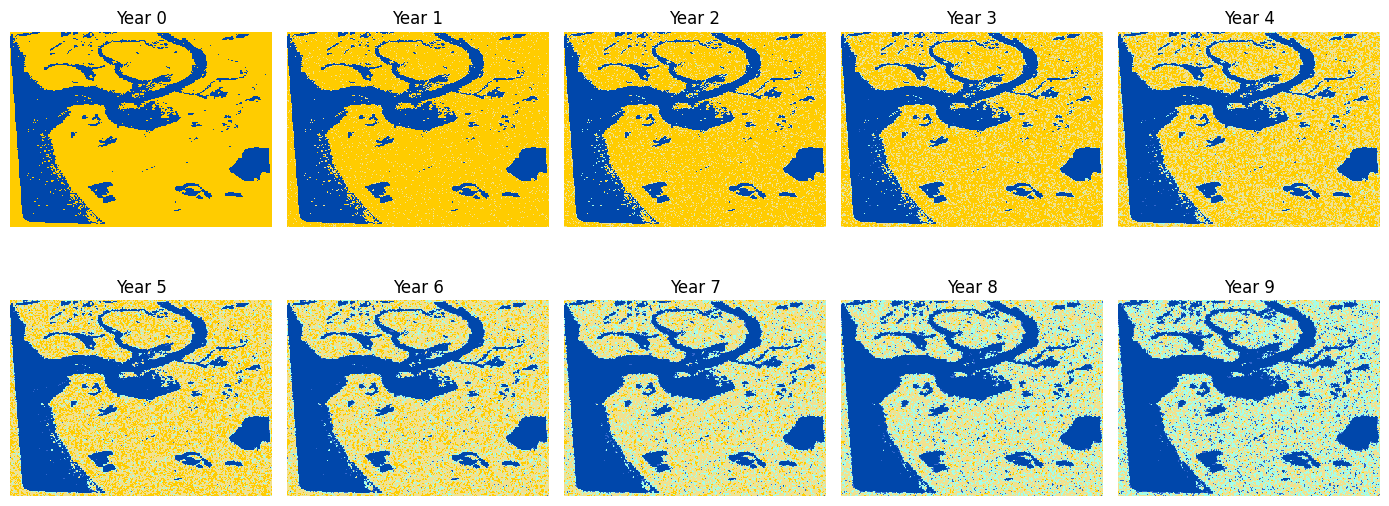

In [53]:
# Cell C2: Run CA simulation and visualize

steps = 50  # ~50 years if you interpret 1 step = 1 yr
n_snapshots = 10  # how many frames to plot

fig, axes = plt.subplots(2, 5, figsize=(14, 6))
axes = axes.flatten()

current_grid = grid.copy()

for step in range(steps):
    # Show early evolution
    if step < n_snapshots:
        ax = axes[step]
        im = ax.imshow(current_grid, cmap=cmap, vmin=WATER, vmax=LAND, interpolation="nearest")
        ax.set_title(f"Year {step}")
        ax.axis("off")

    # Trigger an extreme flood mid-simulation
    if step == 20:
        current_grid = storm_flood(current_grid, flood_intensity=3)

    # Evolve
    current_grid = update_grid(current_grid)

plt.tight_layout()
plt.show()
